In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import requests
import json
import os
import logging
import pickle
import seaborn as sns
import time
import datetime
from scipy.optimize import curve_fit

In [2]:
def removeNA(data):
    return [i for i in data if i['gps_lon'] != 'N/A' and i['gps_lat'] != 'N/A' and i['gps_lon'] != 0 and i['gps_lat'] != 0]
def reserveGPS(data, lon_min, lon_max, lat_min, lat_max):
    return [i for i in data if i['gps_lon'] >= lon_min and i['gps_lon'] < lon_max and i['gps_lat'] >= lat_min and i['gps_lat'] < lat_max]


In [4]:
with open('airboxHistory.json') as file:
    history = json.load(file)

In [5]:
strbasetime = list(history['device'][0]['AirBox'][0].keys())[0]
basetime=time.mktime(datetime.datetime.strptime(strbasetime, "%Y-%m-%dT%H:%M:%SZ").timetuple())+3600*8
basetime -= basetime % 3600
print(strbasetime)
print(basetime)
print(history['device'][0]['AirBox'][0])

2019-01-15T13:22:43Z
1547557200.0
{'2019-01-15T13:22:43Z': {'s_3': 0.0, 'ver_format': '3', 'app': 'AirBox', 's_t0': 22.75, 'gps_lat': 24.999, 's_h0': 79.0, 's_d0': 18.0, 's_d1': 21.0, 'date': '2019-01-15', 'time': '13:22:43', 'ver_app': '1.0.7', 'gps_fix': 1.0, 's_0': 186.0, 's_2': 1.0, 'gps_num': 9.0, 's_1': 100.0, 's_d2': 10.0, 'tick': 1547558563.0, 'device_id': '74DA38F7C368', 'fmt_opt': '1', 'gps_lon': 121.521, 'timestamp': '2019-01-15T13:22:43Z', 'gps_alt': 2.0}}


In [6]:
# setting
max_lon = 121.6
min_lon = 121.3
min_lat = 24.9
max_lat = 25.2
resolution = 0.01 #distance resolution
time_slot = 1 # minutes
lon_cell_num = 30
lat_cell_num = 30

data_type = 's_d2'

# write how to derive function in the paper
# use meter and seconds while writing.

def time_func(x, a, b, c):
    return a*np.exp(-(b*x))+c
dist_func_format = '{:.2f}*e^(-{:.2f}x)+{:.2f}'

def dist_func(x, a, b, c):
    return a*np.exp(-(b*x))+c
time_func_format = '{:.2f}*e^(-{:.2f}x)+{:.2f}'


def offset_generater(a):
    #print(max(a))
    return 0.05*max(a)

max_time_slot = 24 # # of time_slot
max_dist = 30

# Data Types
#    "s_g8": "TVOC (ppb)",
#    "s_b0": "barometric pressure (mmHg)",
#    "s_t0": "Temperature (degree, C)"
#    "s_d2": "PM1 (ug/m3)",
#    "s_g8e": "CO2 equivalent (ppb)",
#    "s_d0": "PM2.5 (ug/m3)",
#    "s_d1": "PM10 (ug/m3)",
#    "s_h0": "Relative humidity (%)",
#    "s_gg": "CO2 (ppm)"

In [7]:
# +1 for the error of floating point representation
cell = 0
cell = [[[[] for i in range(lon_cell_num)]
         for j in range(lat_cell_num)] 
        for z in range(int(24*8*60/time_slot))]

for device in history['device']:
    if 'AirBox' in list(device.keys()):
        device = device['AirBox']
    else:
        device = device['AirBox2']
    for data in device:
        timestamp = list(data.keys())[0]
        tick = data[timestamp]['tick']
        lon = data[timestamp]['gps_lon']
        lat = data[timestamp]['gps_lat']
        if(lon >= max_lon or lon < min_lon or lat >= max_lat or lat < min_lat or data[timestamp][data_type] > 100):
            continue
        cell[int((tick-basetime)/(60*time_slot))][int((lon-min_lon)/0.01)][int((lat-min_lat)/0.01)].append(data[timestamp][data_type])
        
cell_avg = [[[[] for i in range(lon_cell_num)]
         for j in range(lat_cell_num)] 
        for z in range(int(24*8*60/time_slot))]
for i_idx, i in enumerate(cell):
    for j_idx, j in enumerate(i):
        for k_idx, k in enumerate(j):
            cell_avg[i_idx][j_idx][k_idx] = np.average(k)
            


/home/chao/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/chao/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


initilize arrays
0.73*e^(-4.91x)+0.27


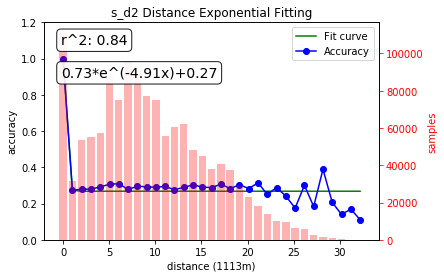

In [7]:
corrcoef = []
dist = []
dist_error = []
for t in range(int(7*24*60/time_slot)):
    for i in range(lon_cell_num):
        for j in range(lat_cell_num):
            if(not np.isnan(cell_avg[t][i][j])):
                for x in range(lon_cell_num):
                    for y in range(lat_cell_num):
                        if(not np.isnan(cell_avg[t][x][y])):
                            dist.append(((x-i)**2+(y-j)**2)**0.5)
                            dist_error.append(abs(cell_avg[t][i][j] - cell_avg[t][x][y]))
dist = np.array(dist)
dist_error = np.array(dist_error)
textstr = 'corrcoef: ' + str(np.corrcoef(dist, dist_error, rowvar=0)[0][1])
corrcoef.append(np.corrcoef(dist, dist_error, rowvar=0)[0][1])
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

avg = [[] for i in range(int(max(dist))+1)]
mean = [0 for i in range(int(max(dist))+1)]
accuracy = []
length = []

print("initilize arrays")
for idx, i in enumerate(dist):
    avg[int(i)].append(dist_error[idx])
for idx, a in enumerate(avg):
    a_mean = np.average(a)
    mean[idx] = a_mean
    offset = offset_generater(a)
    count = list(filter(lambda x: x <= a_mean+offset and x >= a_mean-offset, a))
    accuracy.append(len(count)/len(a))
    length.append(len(a))

xdata = np.linspace(0, max(dist), len(accuracy))
popt, pcov = curve_fit(dist_func, xdata, accuracy, maxfev=50000)
residuals = accuracy - dist_func(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((accuracy-np.mean(accuracy))**2)

r_squared = 1-(ss_res/ss_tot)

%matplotlib inline
fig,ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.bar(xdata, length, fc=(1, 0, 0, 0.3), label='S')
ax2.set_ylabel('samples', color='r')
ax2.tick_params('y', colors='r')

textstr = 'r^2: %.2f' %(r_squared)
equation_str = dist_func_format.format(*popt)
print(equation_str)
plt.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
plt.text(0.05, 0.8, equation_str, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
ax1.plot(xdata, dist_func(xdata, *popt), c='green', label='Fit curve')
ax1.plot(xdata, accuracy, c='blue', label='Accuracy', marker='o')


plt.title(data_type + ' Distance Exponential Fitting')
ax1.set_xlabel('distance (1113m)')
ax1.set_ylabel('accuracy')
ax1.set_ylim(top=1.2, bottom = 0.0)
# Make a legend
legend = ax1.legend(loc='upper right')
plt.savefig('spacial-accuracy-curve-fit-all.eps', format='eps')
plt.show()

In [8]:
corrcoef = []
time_error = []
error = []
for j in range(lon_cell_num):
    for k in range(lat_cell_num):
        for x in range(int(24*7*60/time_slot)):
            for y in range(int(24*7*60/time_slot)):
                if np.isnan(cell_avg[x][j][k]) or np.isnan(cell_avg[y][j][k]) or abs(x-y)>max_time_slot:
                    continue
                else:
                    time_error.append(abs(x-y))
                    error.append(abs(cell_avg[x][j][k] - cell_avg[y][j][k]))


initilize arrays


No handles with labels found to put in legend.


0.70*e^(-26.56x)+0.30


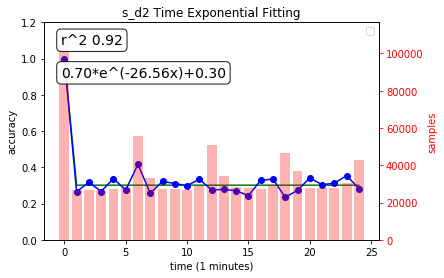

In [9]:
avg = [[] for i in range(int(max(time_error))+1)]
mean = [0 for i in range(int(max(time_error))+1)]
accuracy = []
length = []

print("initilize arrays")

for idx, i in enumerate(time_error):
    avg[int(i)].append(error[idx])
for idx, a in enumerate(avg):
    a_mean = np.average(a)
    mean[idx] = a_mean
    max_error = max(a)
    offset = offset_generater(a)
    count = list(filter(lambda x : x <= a_mean+offset and x >= a_mean-offset, a))
    accuracy.append(len(count)/len(a))
    length.append(len(a))

props = dict(boxstyle='round', facecolor='white', alpha=0.9)

xdata = np.linspace(0, max(time_error), len(accuracy))
popt, pcov = curve_fit(time_func, xdata, accuracy, maxfev=50000)
residuals = accuracy - time_func(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((accuracy-np.mean(accuracy))**2)

r_squared = 1-(ss_res/ss_tot)

%matplotlib inline
textstr = 'r^2 %.2f' %(r_squared)
equation_str = time_func_format.format(*popt)
print(equation_str)

fig,ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.bar(xdata, length, fc=(1, 0, 0, 0.3))
ax2.set_ylabel('samples', color='r')
ax2.tick_params('y', colors='r')

plt.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
plt.text(0.05, 0.8, equation_str, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
ax1.plot(xdata, time_func(xdata, *popt), c='green', label='Fit curve')
ax1.plot(xdata, accuracy, c='blue', label='Accuracy', marker='o')
plt.title(data_type + ' Time Exponential Fitting')
ax1.set_xlabel('time (%s minutes)'%(time_slot))
ax1.set_ylabel('accuracy')
ax1.set_ylim(top=1.2, bottom = 0.0)
# Make a legend
legend = plt.legend(loc='upper right')
plt.savefig('temporal-accuracy-fit.eps', format='eps')
plt.show()

## Hourly Impact Functions
### s_h0 :
* spatial impact: 0.71*e^0(-2.74)+0.29
* temporal impact: 0.58*e^(-0.45x)+0.31

### s_t0 :
* spatial impact: 0.72*e^(-2.16x)+0.28
* temporal impact: 0.48*e^(-0.18x)+0.53

### s_d0 :
* spatial impact: 0.68*e^(-1.85x)+0.32
* temporal impact: 0.71*e^(-0.37x)+0.27

### s_d1 :
* spatial impact: 0.79*e^(-6.10x)+0.21
* temporal impact: 0.75*e^(-0.56x)+0.22

### s_d2 :
* spatial impact: 0.65*e^(-2.25x)+0.35
* temporal impact: 0.55*e^(-0.24x)+0.45
---
## Minutely Impact Functions
### s_h0 :
* spatial impact: 0.71*e^0(-2.74)+0.29
* temporal impact: 0.58*e^(-0.45x)+0.31

### s_t0 :
* spatial impact: 0.72*e^(-2.16x)+0.28
* temporal impact: 0.48*e^(-0.18x)+0.53

### s_d0 :
* spatial impact: 0.68*e^(-1.85x)+0.32
* temporal impact: 0.71*e^(-0.37x)+0.27

### s_d1 :
* spatial impact: 0.79*e^(-6.10x)+0.21
* temporal impact: 0.75*e^(-0.56x)+0.22

### s_d2 :
* spatial impact: 0.73*e^(-4.91x)+0.27
* temporal impact: 0.73*e^(-4.91x)+0.27

In [10]:
time_slot

1